In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd

# Relatório: Problema do Caixeiro Viajante
Nome: Anakin Dantas Rodrigues \
Matrícula: 2023033173

Neste trabalho, serão testados dois métodos diferentes para resolver o problema do Caixeiro Viajante: o Algoritmo Genético (AG) e o Simulated Annealing (SA). Ambos tentam encontrar o menor caminho possível para visitar várias cidades sem repetir nenhuma.

# Rotinas AG

In [42]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

# N = 120  # Número de cidades

# Define posições iniciais para as cidades
def set_positions(N):
    x = np.random.rand(N)
    y = np.random.rand(N)
    return x, y

# # Define posições aleatórias para as cidades
# x, y = set_positions(N)

# Define a distância entre duas cidades quaisquer
@jit(nopython=True)
def distances(N, x, y):
    dist = np.zeros((N, N), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i, j] = np.sqrt((x[i] - x[j]) * (x[i] - x[j]) + (y[i] - y[j]) * (y[i] - y[j]))
    return dist  # Retorna a matriz de distâncias

@jit(nopython=True)  # Calcula aptidão (energia)
def apt(ps, dist):
    # ps é uma lista (array) que contém o caminho. Pode conter mais de um caminho,
    # um para cada indivíduo, por exemplo
    apts = np.zeros(len(ps), dtype=np.float32)  # Cria um array para alocar a aptidão de cada indivíduo
    count = 0
    for p in ps:  # Loop sobre os indivíduos
        a = 0
        for i in range(len(p) - 1):  # Loop ao longo do caminho
            a += dist[p[i], p[i + 1]]
        a += dist[p[0], p[-1]]
        apts[count] = a
        count += 1
    return apts  # Retorna os valores de aptidão calculados

@jit(nopython=True)  # Mutação 1 - Inversion
def mutacao_1(path):
    N = len(path)  # Número de cidades
    newpath = np.zeros(N, dtype=np.int32)  # Aloca o vetor com o novo caminho

    # Define índices aleatórios, ini e fin, com ini < fin
    i1 = np.random.randint(N)
    fin = i1
    while fin == i1:
        fin = np.random.randint(N)

    if i1 > fin:
        ini = fin
        fin = i1
    else:
        ini = i1

    for k in range(N):  # Inverte o sentido em que percorre o caminho entre os índices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin - k + ini]
        else:
            newpath[k] = path[k]
    return newpath  # Retorna o caminho modificado

@jit(nopython=True)  # Mutação 2 - Reciprocal Exchange
def mutacao_2(path):
    N = len(path)  # Número de cidades
    newpath = np.copy(path)

    i = np.random.randint(N)  # Escolhe uma posição aleatória da caminhada
    j = i
    while j == i:
        j = np.random.randint(N)  # Escolhe outra posição diferente da já escolhida

    a = path[i]
    b = path[j]

    # Realiza a inversão
    newpath[j] = a
    newpath[i] = b

    return newpath  # Retorna o caminho modificado

@jit(nopython=True)  # Cross OX
def cross_ox(pai1, pai2):
    N = len(pai1)  # Número de cidades
    o1 = np.zeros(N, dtype=np.int32)  # Aloca os vetores para os filhos
    o2 = np.zeros(N, dtype=np.int32)

    # Gera índices, i e j, com j > i
    i1 = np.random.randint(N)
    j = i1
    while j == i1:
        j = np.random.randint(N)

    if i1 > j:
        i = j
        j = i1
    else:
        i = i1

    # Coloca em o1 as cidades de pai2 que não estão dentro do intervalo i,j em pai1
    # na ordem em que elas aparecem em pai2 a partir de j
    k2 = j
    k3 = j
    while k3 != i:
        if pai2[k2] not in pai1[i:j]:
            o1[k3] = pai2[k2]
            k3 += 1
            if k3 == N: k3 = 0
        k2 += 1
        if k2 == N: k2 = 0

    # Coloca em o2 as cidades de pai1 que não estão dentro do intervalo i,j em pai2
    # na ordem em que elas aparecem em pai1 a partir de j
    k2 = j
    k3 = j
    while k3 != i:
        if pai1[k2] not in pai2[i:j]:
            o2[k3] = pai1[k2]
            k3 += 1
            if k3 == N: k3 = 0
        k2 += 1
        if k2 == N: k2 = 0

    # Copia dos pais os pedaços que serão preservados
    o1[i:j] = pai1[i:j]
    o2[i:j] = pai2[i:j]

    return o1, o2  # Retorna os dois filhos gerados

@jit(nopython=True)  # Cross PMX
def cross_pmx(pai1, pai2):
    N = len(pai1)  # Número de cidades
    o1 = np.zeros(N, dtype=np.int32)  # Aloca os vetores para os filhos
    o2 = np.zeros(N, dtype=np.int32)

    mapeia1 = np.zeros(N, dtype=np.int32)  # Aloca os vetores para o mapeamento
    mapeia2 = np.zeros(N, dtype=np.int32)

    mapeia1 += N + 5  # Inicia os vetores de mapeamento com valores maiores que N
    mapeia2 += N + 5

    # Escolhe índices, i e j, com j > i
    i1 = np.random.randint(N)
    j = i1
    while j == i1:
        j = np.random.randint(N)
    if i1 > j:
        i = j
        j = i1
    else:
        i = i1

    # Copia em o1 e o2 as cidades no intervalo i, j contidas em pai2 e pai1, respectivamente
    # e estabelece o mapeamento a ser feito para o restante do caminho
    for k in range(i, j):
        o1[k] = pai2[k]
        o2[k] = pai1[k]
        mapeia1[pai2[k]] = pai1[k]
        mapeia2[pai1[k]] = pai2[k]

    # Preenche o restante das posições de o1 e o2 utilizando o mapeamento definido
    # no intervalo 0 a i
    for k in range(0, i):
        o1[k] = pai1[k]
        cond = mapeia1[o1[k]]
        while cond < N + 1:
            cond = mapeia1[o1[k]]
            if cond < N + 1: o1[k] = cond

        o2[k] = pai2[k]
        cond = mapeia2[o2[k]]
        while cond < N + 1:
            cond = mapeia2[o2[k]]
            if cond < N + 1: o2[k] = cond

    # Preenche o restante das posições de o1 e o2 utilizando o mapeamento definido
    # no intervalo j a N
    for k in range(j, N):
        o1[k] = pai1[k]
        cond = mapeia1[o1[k]]
        while cond < N + 1:
            cond = mapeia1[o1[k]]
            if cond < N + 1: o1[k] = cond

        o2[k] = pai2[k]
        cond = mapeia2[o2[k]]
        while cond < N + 1:
            cond = mapeia2[o2[k]]
            if cond < N + 1: o2[k] = cond

    return o1, o2  # Retorna os dois filhos gerados

@jit(nopython=True)  # Cross CX
def cross_cx(p1, p2):
    N = len(p1)  # Número de cidades
    o1 = np.zeros(N, dtype=np.int32)  # Aloca os vetores dos filhos
    o2 = np.zeros(N, dtype=np.int32)

    o1 -= 1  # Inicia os filhos com valores negativos
    o2 -= 1

    # Partindo da primeira cidade em pai1 vai preenchendo o1 com
    # as cidades de pai2 nas posições que elas ocupam em pai1 enquanto for possível
    next = 0
    o1[next] = p1[next]
    cond = True
    while cond:
        if p2[next] not in o1:
            city = p2[next]
            next = np.where(p1 == city)[0].item()
            o1[next] = city
        else:
            cond = False

    # Preenche as posições restantes com as cidades do pai2
    o1 = np.where(o1 < 0, p2, o1)

    # Partindo da primeira cidade em pai2 vai preenchendo o2 com
    # as cidades de pai1 nas posições que elas ocupam em pai2 enquanto for possível
    next = 0
    o2[next] = p2[next]
    cond = True
    while cond:
        if p1[next] not in o2:
            city = p1[next]
            next = np.where(p2 == city)[0].item()
            o2[next] = city
        else:
            cond = False

    # Preenche as posições restantes com as cidades do pai2
    o2 = np.where(o2 < 0, p1, o2)

    return o1, o2  # Retorna os dois filhos gerados

@jit(nopython=True)
def newpath_de(path, dist):  # Retorna um novo caminho e a diferença na distância percorrida
    N = len(path)  # Número de cidades
    newpath = np.zeros(N, dtype=np.int16)  # Aloca o novo caminho

    i = np.random.randint(N)  # Escolhe uma posição aleatória da caminhada
    j = i
    while j == i:
        j = np.random.randint(N)  # Escolhe outra posição
    if i > j:  # Ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):  # Inverte o sentido em que percorre o caminho entre os índices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin - k + ini]
        else:
            newpath[k] = path[k]

    esq = ini - 1  # Cidade anterior a inicial
    if esq < 0: esq = N - 1  # Condição de contorno
    dir = fin + 1  # Cidade após a final
    if dir > N - 1: dir = 0  # Condição de contorno

    # Calcula a diferença na distância total percorrida ao trocar o caminho
    de = -dist[path[esq], path[ini]] - dist[path[dir], path[fin]] + dist[newpath[esq], newpath[ini]] + dist[newpath[dir], newpath[fin]]

    return newpath, de  # Retorna o novo caminho e a diferença na distância

# Algoritmo Genético


Para solucionar o problema, considerou-se uma população de 20 individuos, onde cada individuo representa um possível caminho entre N cidades. \
\
**Critérios utilizados**: \
1) Os dois melhores indivíduos (caminhos que percorrem as menores distâncias) são clonados para a próxima geração. \
2) Dois indivíduos da próxima geração são mutações do melhor indivíduo. \
3) Os pais são selecionados com probabilidade proporcional à aptidão. \
4) Para cada casal de pais selecionados, são gerados 2 filhos. O filho mais apto dentre os dois passa diretamente para a próxima geração. O segundo filho que passa para a próxima geração é uma mutação de um dos dois filhos (com probabilidade de 70% de ser uma mutação do filho mais apto e 30% de ser uma mutação do filho menos apto).


In [92]:
# Parâmetros

populacao = 20 # Tamanho da população
melhores_ind = 2 # Número de melhores indivíduos que passam diretamente para a próxima geração
taxa_mut = 0.2  # Taxa de mutação
max_ger = 10000  # Número máximo de gerações
estagnacao = 1000   # Número de gerações sem melhoria
mutacoes_do_melhor = 2  # Número de mutações do indivíduo mais apto que passam para a próxima geração

In [93]:
@jit(nopython=True)
def init_populacao(populacao, N): #Inicializa a população
  path = np.arange(N, dtype=np.int32) #Define um caminho ordenado da cidade 0 à cidade 9
  ps = np.zeros((populacao, N), dtype=np.int32) #Inicia o conjunto de "individuos" (caminhos)

  for i in range(populacao): #Gera "individuos"(caminhos) aleatórios que são permutações do primeiro caminho
    ps[i] = path
    np.random.shuffle(path)

  return ps

In [94]:
# Função de seleção dos pais por roleta (proporcional à aptidão)
def selecao_roleta(ps, apts):
    # Os valores de distâncias totais (apts) são invertidos pois queremos minimizar a distância
    # Quanto maior a aptidao, menor a distância
    aptidao = 1.0 / (apts + 1e-10)  # Adiciona-se um pequeno valor para evitar divisão por zero
    total_apts = np.sum(aptidao)
    probabilidade = aptidao / total_apts

    # Seleciona dois pais baseado nas probabilidades
    indices = np.random.choice(len(ps), size=2, p=probabilidade)
    return ps[indices[0]], ps[indices[1]]

In [95]:
import time

# Algoritmo genético principal
def AlgoritmoGenetico(N, x=None, y=None, plot_results=True):
    # Configura as posições das cidades se não fornecidas
    if x is None or y is None:
        x, y = set_positions(N)

    # Calcula a matriz de distâncias
    dist = distances(N, x, y)

    # Inicializa a população
    ps = init_populacao(populacao, N)

    # Armazena o histórico da melhor distância
    evolucao_dists = []

    # Variáveis para controle de estagnação
    estagnacao_counter = 0
    melhor_dist_global = float('inf')

    start_time = time.time()

    for geracao in range(max_ger):
        # Calcula a distância percorrida de cada indivíduo (caminho)
        apts = apt(ps, dist)

        # Encontra o melhor indivíduo
        melhor_ind = np.argmin(apts)
        melhor_dist = apts[melhor_ind]
        evolucao_dists.append(melhor_dist)

        # Verifica se houve melhoria
        if melhor_dist < melhor_dist_global:
            melhor_dist_global = melhor_dist
            melhor_path = ps[melhor_ind].copy()
            estagnacao_counter = 0
        else:
            estagnacao_counter += 1

        # Critério de parada por estagnação
        if estagnacao_counter >= estagnacao:
            print(f"Estagnação atingida na geração {geracao}. Melhor distância: {melhor_dist_global:.4f}")
            break

        # Cria a nova geração
        new_ger = np.zeros_like(ps)

        # Elitismo: mantém os melhores indivíduos
        # Ordena os índices dos indivíduos da população atual (ps) com base em suas aptidões (apts), do menor para o maior valor.
        elite_indices = np.argsort(apts)[:melhores_ind]
        new_ger[:melhores_ind] = ps[elite_indices]

        # Cria 2 mutações do melhor indivíduo
        for i in range(mutacoes_do_melhor):
          # Escolhe aleatoriamente entre mutacao_1 e mutacao_2
          if np.random.rand() < 0.5:
              new_ger[melhores_ind + i] = mutacao_1(melhor_path.copy())
          else:
              new_ger[melhores_ind + i] = mutacao_2(melhor_path.copy())

        # Preenche o restante da nova população
        for i in range((melhores_ind + mutacoes_do_melhor), populacao, 2):
            # Seleciona os pais
            pai1, pai2 = selecao_roleta(ps, apts)

            # Aplica crossover (escolhe aleatoriamente entre os métodos disponíveis)
            crossover_method = np.random.randint(0, 3)
            if crossover_method == 0:
                filho1, filho2 = cross_ox(pai1, pai2)
            elif crossover_method == 1:
                filho1, filho2 = cross_pmx(pai1, pai2)
            else:
                filho1, filho2 = cross_cx(pai1, pai2)

            # Calcula aptidão dos filhos
            apt_filho1 = apt([filho1], dist)[0]
            apt_filho2 = apt([filho2], dist)[0]

            if apt_filho1 < apt_filho2:
                filho_mais_apto, filho_menos_apto = filho1, filho2
            else:
                filho_mais_apto, filho_menos_apto = filho2, filho1

            # Inclui o filho mais apto
            new_ger[i] = filho_mais_apto

            # Aplica mutação híbrida (70% de chance de gerar uma mutação do mais apto, 30% do menos apto)
            if np.random.rand() < 0.7:
                new_ger[i+1] = mutacao_1(filho_mais_apto.copy()) if np.random.rand() < 0.5 else mutacao_2(filho_mais_apto.copy())
            else:
                new_ger[i+1] = mutacao_1(filho_menos_apto.copy()) if np.random.rand() < 0.5 else mutacao_2(filho_menos_apto.copy())


        # Substitui a população antiga pela nova
        ps = new_ger

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"\nResultados para N={N} cidades:")
    print(f"Melhor distância encontrada: {melhor_dist_global:.4f}")
    print(f"Tempo de execução: {execution_time:.2f} segundos")
    print(f"Número de gerações: {len(evolucao_dists)}")

    if plot_results:
        # Plota a evolução da melhor distância
        plt.figure(figsize=(10, 5))
        plt.plot(evolucao_dists, 'b-', linewidth=1)
        plt.title(f'Evolução da Melhor Distância (N={N})')
        plt.xlabel('Geração')
        plt.ylabel('Distância')
        plt.grid(True)
        plt.show()

         # Plota o melhor caminho encontrado
        plt.figure(figsize=(8, 8))
        plt.scatter(x, y, c='red', s=50)

        # Desenha as linhas do caminho
        for i in range(N-1):
            plt.plot([x[melhor_path[i]], x[melhor_path[i+1]]],  # X coordinates
                    [y[melhor_path[i]], y[melhor_path[i+1]]],  # Y coordinates
                    'b-')  # Linha azul

        # Conecta a última cidade de volta à primeira
        plt.plot([x[melhor_path[-1]], x[melhor_path[0]]],
                [y[melhor_path[-1]], y[melhor_path[0]]],
                'b-')

        # Marca as cidades com pontos azuis
        plt.plot(x[melhor_path], y[melhor_path], 'bo')

        plt.title(f'Melhor Caminho Encontrado (Distância: {melhor_dist_global:.4f})')
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.grid(True)
        plt.show()

    return melhor_path, melhor_dist_global, evolucao_dists

In [96]:
# Função para resolver múltiplos problemas de tamanhos diferentes
def solve_multiple_problems(n):
    results = {}

    for N in n:
        print(f"\nResolvendo problema com N={N} cidades...")
        x, y = set_positions(N)
        melhor_path, melhor_dist_global, evolucao_dists = AlgoritmoGenetico(N, x, y)
        results[N] = {
            'melhor_caminho': melhor_path,
            'melhor distancia': melhor_dist_global,
            'evolução de distâncias': evolucao_dists,
            'cidades': (x, y)
        }

    return results


Resolvendo problema com N=10 cidades...
Estagnação atingida na geração 1022. Melhor distância: 2.6381

Resultados para N=10 cidades:
Melhor distância encontrada: 2.6381
Tempo de execução: 1.31 segundos
Número de gerações: 1023


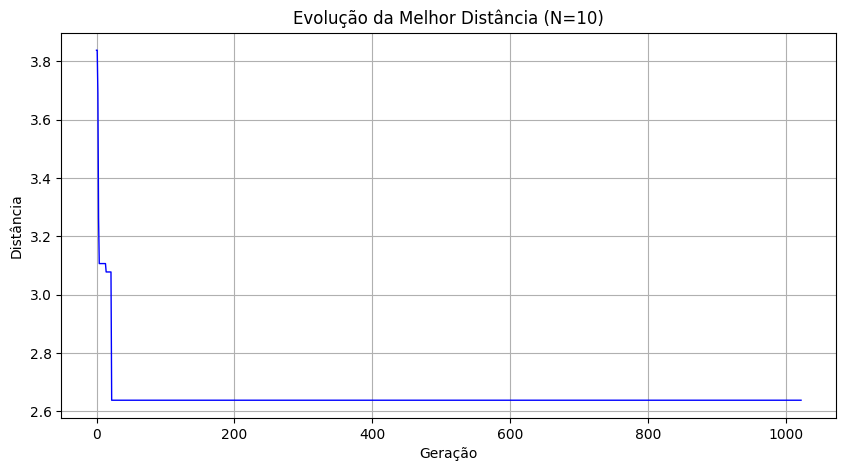

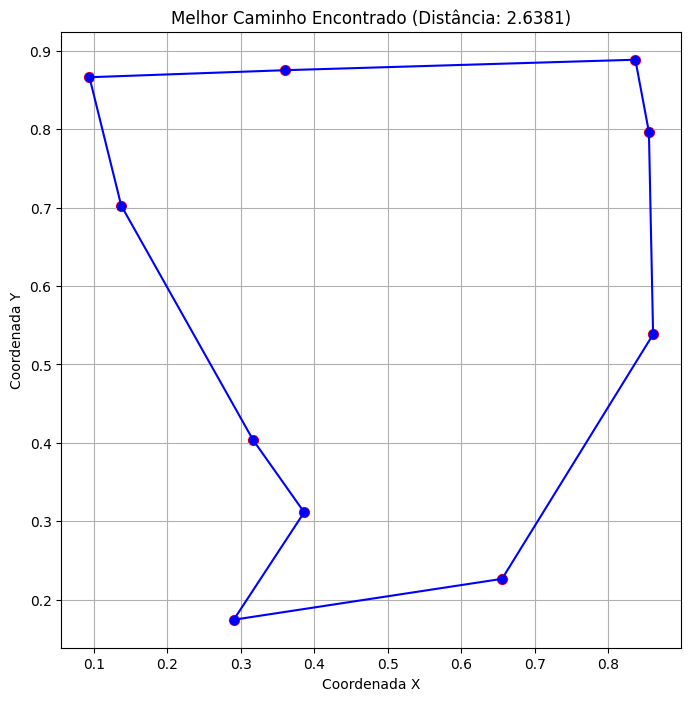


Resolvendo problema com N=25 cidades...
Estagnação atingida na geração 1385. Melhor distância: 4.0292

Resultados para N=25 cidades:
Melhor distância encontrada: 4.0292
Tempo de execução: 1.93 segundos
Número de gerações: 1386


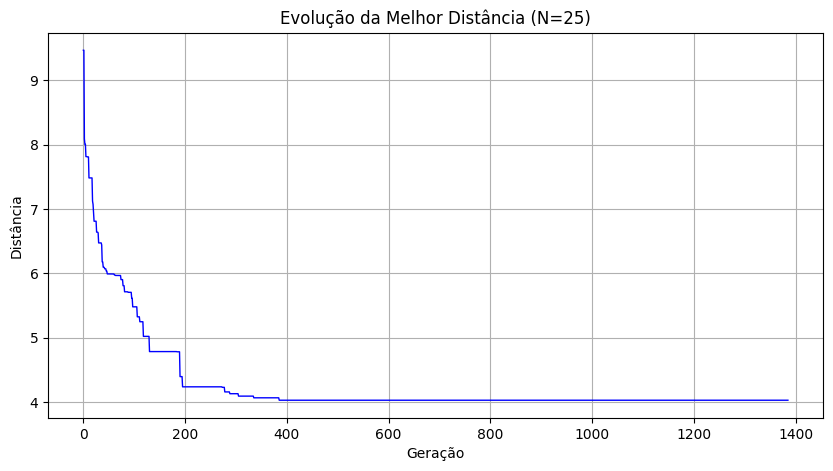

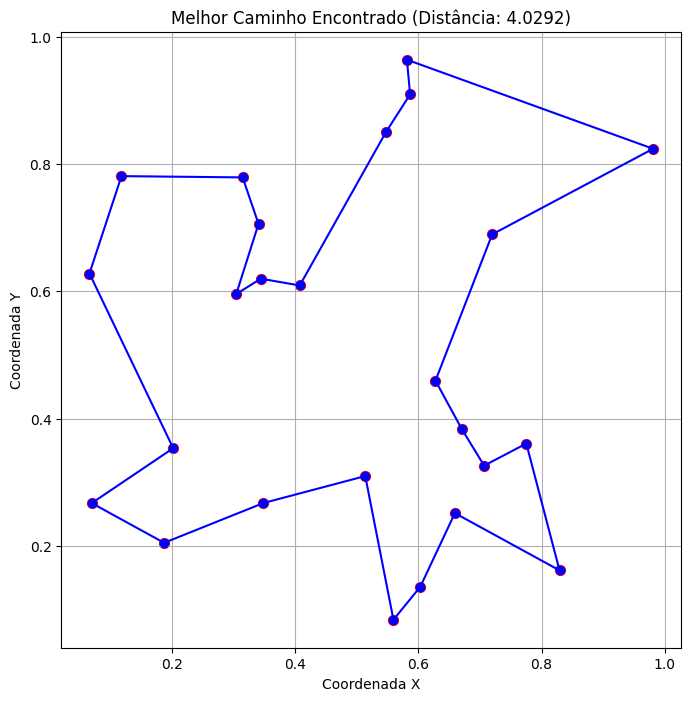


Resolvendo problema com N=50 cidades...
Estagnação atingida na geração 2120. Melhor distância: 5.9263

Resultados para N=50 cidades:
Melhor distância encontrada: 5.9263
Tempo de execução: 3.22 segundos
Número de gerações: 2121


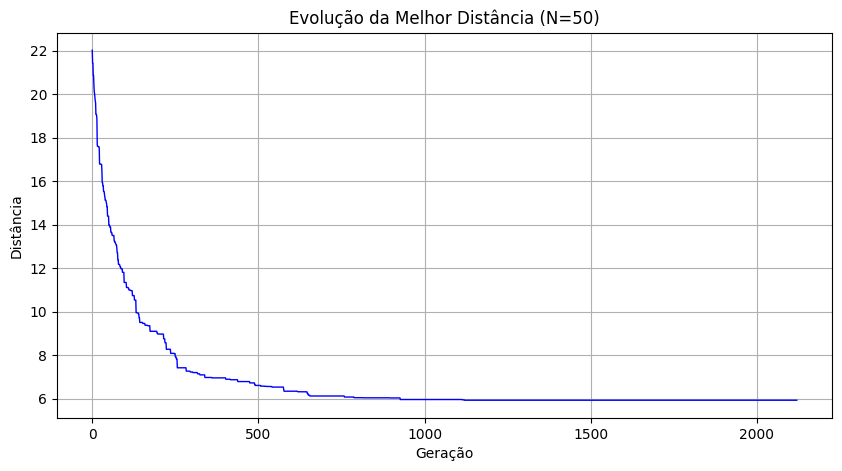

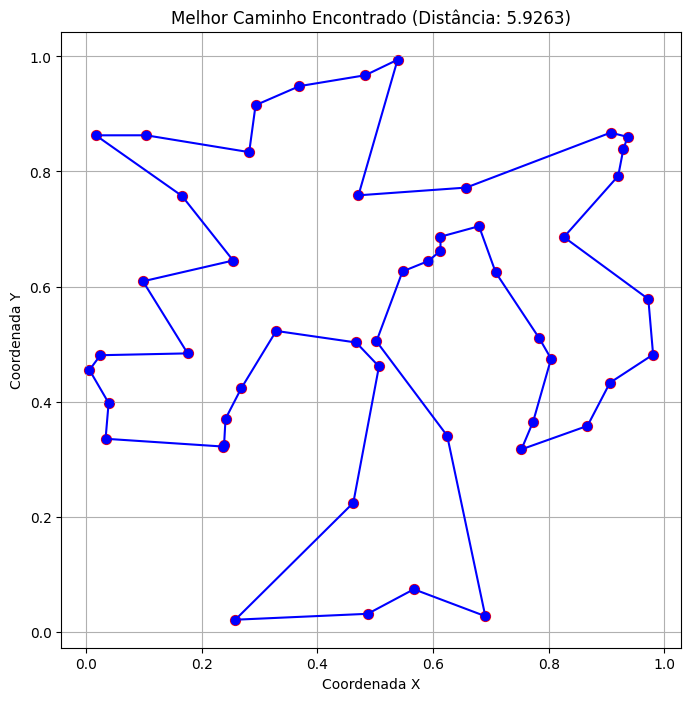


Resolvendo problema com N=75 cidades...
Estagnação atingida na geração 6639. Melhor distância: 6.3902

Resultados para N=75 cidades:
Melhor distância encontrada: 6.3902
Tempo de execução: 8.72 segundos
Número de gerações: 6640


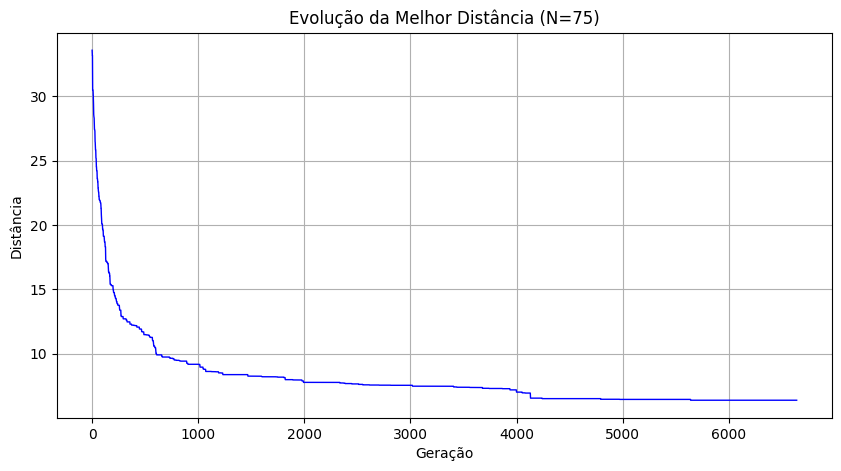

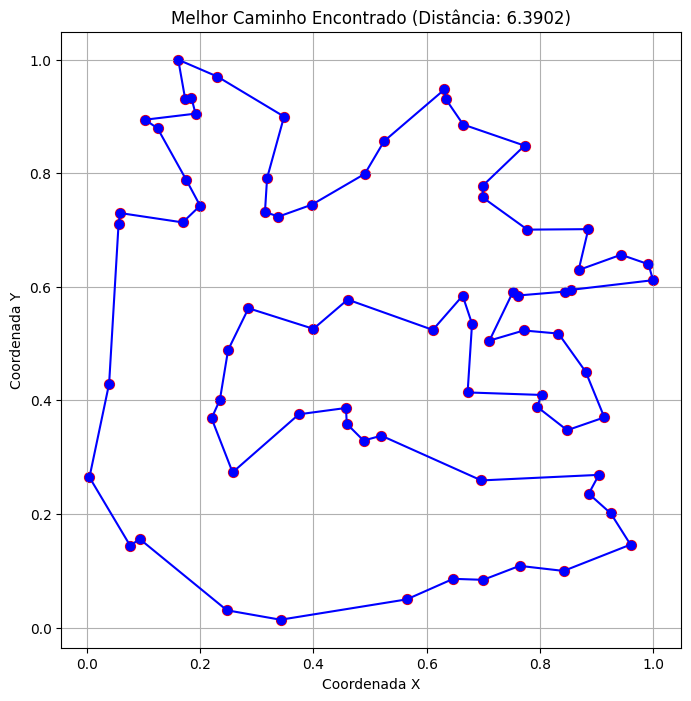


Resolvendo problema com N=100 cidades...

Resultados para N=100 cidades:
Melhor distância encontrada: 8.3884
Tempo de execução: 14.36 segundos
Número de gerações: 10000


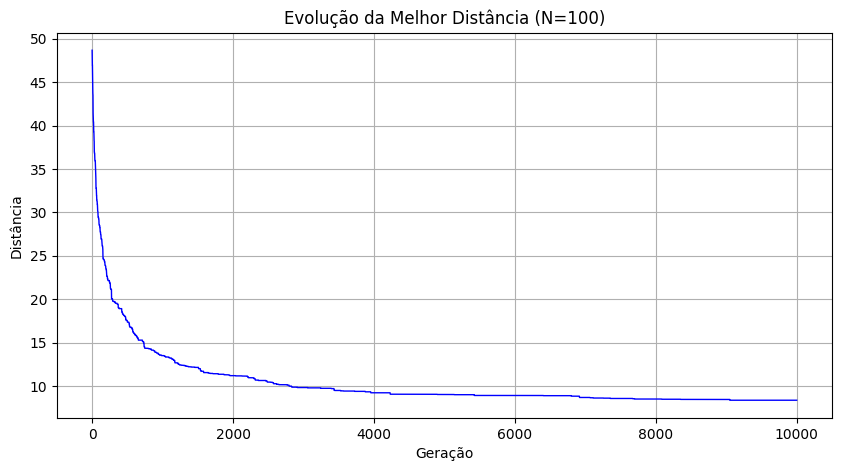

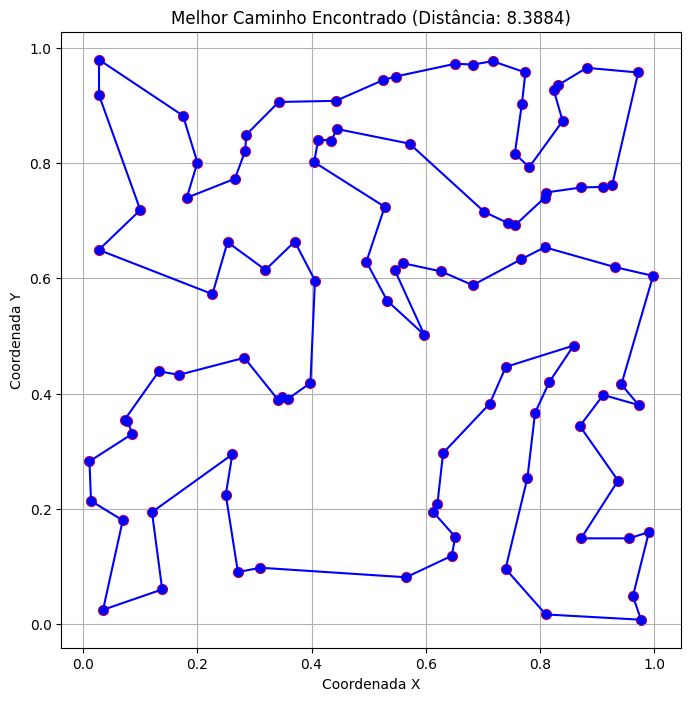


Resolvendo problema com N=125 cidades...
Estagnação atingida na geração 8347. Melhor distância: 9.9592

Resultados para N=125 cidades:
Melhor distância encontrada: 9.9592
Tempo de execução: 11.75 segundos
Número de gerações: 8348


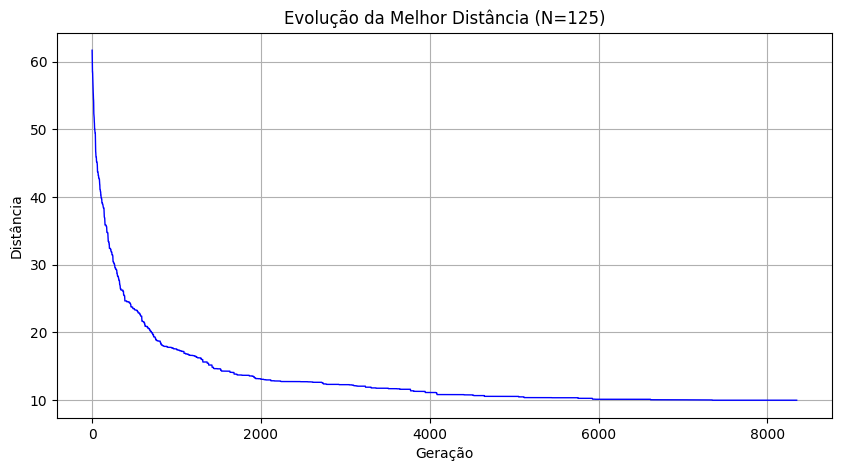

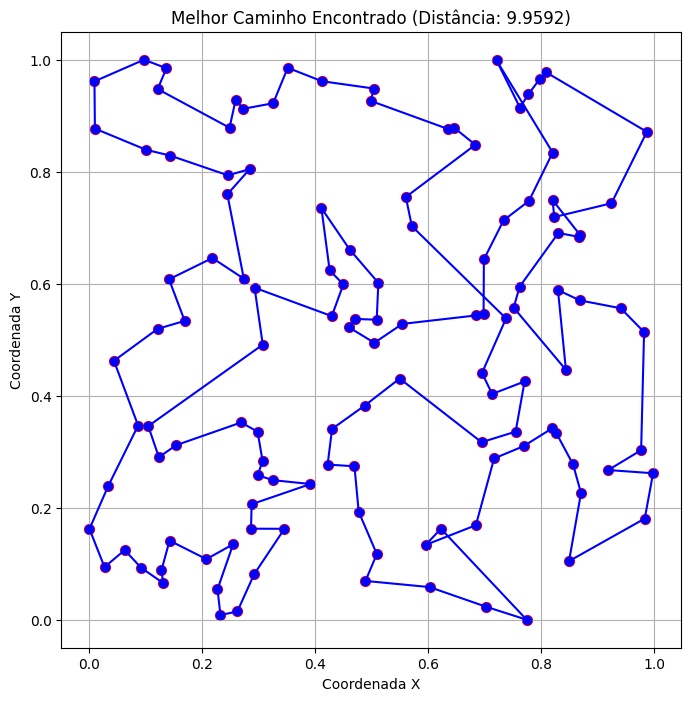


Resolvendo problema com N=150 cidades...

Resultados para N=150 cidades:
Melhor distância encontrada: 11.4763
Tempo de execução: 14.41 segundos
Número de gerações: 10000


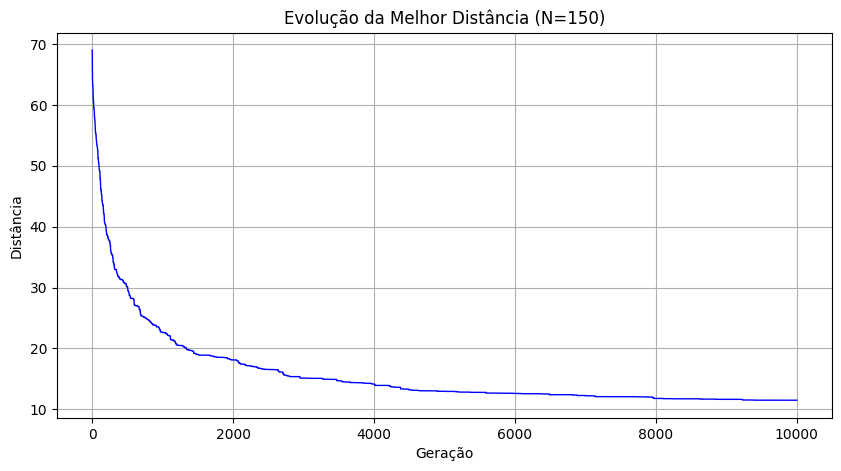

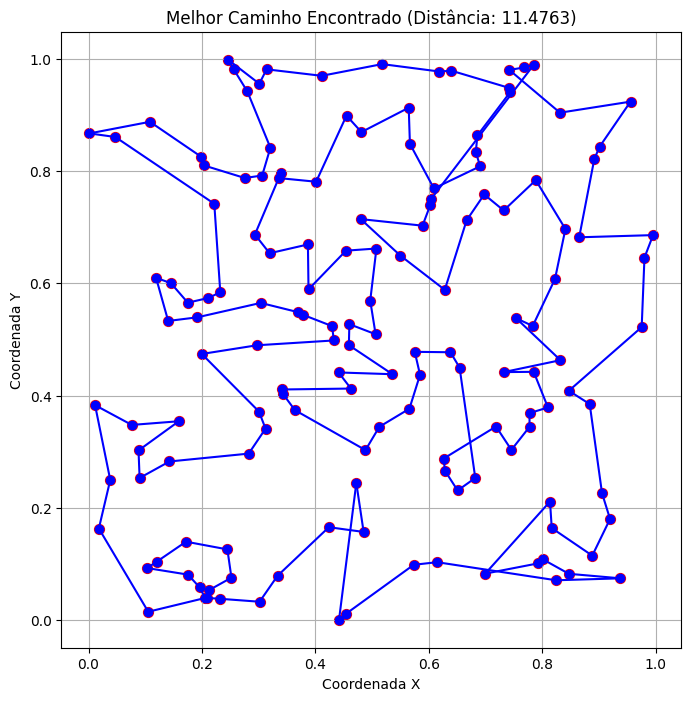

In [97]:
# Define os tamanhos de problemas a serem resolvidos
n = [10, 25, 50, 75, 100, 125, 150]

# Resolve os problemas
results = solve_multiple_problems(n)

# Simulated Annealing
## Algoritmo de Metropolis

In [102]:
# Configurações do Simulated Annealing
temp_ini = 1500.0    # Temperatura inicial alta para permitir exploração
taxa_resf = 0.998     # Taxa de resfriamento
temp_fin = 0.05         # Temperatura final
passos = 2000     # Passos de Monte Carlo por temperatura

In [103]:
def simulated_annealing(N, x=None, y=None, plot_results=True):
    """Implementa Simulated Annealing para o TSP usando mutação Inversion"""

    # Configura posições das cidades se não fornecidas
    if x is None or y is None:
        x, y = set_positions(N)

    # Calcula matriz de distâncias
    dists = distances(N, x, y)

    # Gera caminho inicial aleatório
    path_atual = np.random.permutation(N)
    dist_atual = apt(np.array([path_atual]), dists)[0]

    # Inicializa variáveis para acompanhamento
    melhor_path = path_atual.copy()
    melhor_dist = dist_atual
    temp = temp_ini

    # Listas para armazenar histórico
    evolucao_dists = []
    evolucao_temp = []

    # Pontos estratégicos para amostragem (5 estágios do resfriamento)
    sampling_points = [
        temp_ini * 0.8,    # Fase inicial (alta temp)
        temp_ini * 0.5,    # Fase intermediária
        temp_ini * 0.2,    # Fase de transição
        temp_ini * 0.05,   # Fase de refinamento
        temp_fin * 2         # Fase final (baixa temp)
    ]
    sample_paths = []

    start_time = time.time()
    step = 0

    while temp > temp_fin:
        for _ in range(passos):
            # Gera novo caminho vizinho usando mutação Inversion
            new_path = mutacao_1(path_atual)
            new_dist = apt(np.array([new_path]), dists)[0]

            # Calcula diferença de energia
            delta = new_dist - dist_atual

            # Critério de Metropolis
            if delta < 0 or np.random.rand() < np.exp(-delta / temp): #Aceita soluções piores com probabilidade P = exp[- delta E / T]
                path_atual = new_path
                dist_atual =new_dist

                # Atualiza melhor caminho encontrado
                if dist_atual < melhor_dist:
                    melhor_path = path_atual.copy()
                    melhor_dist = dist_atual

            # Armazena histórico
            evolucao_dists.append(dist_atual)
            evolucao_temp.append(temp)
            step += 1

            # Verifica se atingiu um ponto de amostragem
            for i, temp_point in enumerate(sampling_points):
                if len(sample_paths) <= i and temp <= temp_point:
                    sample_paths.append((temp, path_atual.copy(), dist_atual))
                    break

        # Resfriamento exponencial
        temp *= taxa_resf

    # Garante que temos pelo menos 5 amostras, mesmo que não tenha atingido todos os pontos
    while len(sample_paths) < 5:
        sample_paths.append((temp, path_atual.copy(), dist_atual))

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"\nResultados para N={N} cidades:")
    print(f"Melhor distância encontrada: {melhor_dist:.4f}")
    print(f"Tempo de execução: {execution_time:.2f} segundos")
    print(f"Número total de passos: {step}")

    if plot_results:
        # Plota a evolução da distância com indicação das temperaturas de amostragem
        plt.figure(figsize=(14, 6))

        # Gráfico da evolução
        plt.subplot(1, 2, 1)
        plt.plot(evolucao_dists, 'b-', alpha=0.7, linewidth=0.5)

        # Marca os pontos de amostragem no gráfico
        for i, (temp, path, dist) in enumerate(sample_paths):
            idx = evolucao_temp.index(temp) if temp in evolucao_temp else len(evolucao_dists)//(i+1)
            plt.plot(idx, evolucao_dists[idx], 'ro', markersize=8)
            plt.annotate(f'T={temp:.1f}', (idx, evolucao_dists[idx]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.title('Evolução da Distância com Pontos de Amostragem')
        plt.xlabel('Passo de Simulação')
        plt.ylabel('Distância Total')
        plt.grid(True)

        # Gráfico temperatura vs distância
        plt.subplot(1, 2, 2)
        plt.semilogx(evolucao_temp, evolucao_dists, 'b.', alpha=0.1)

        # Destaca os pontos de amostragem
        for temp, path, dist in sample_paths:
            idx = evolucao_temp.index(temp) if temp in evolucao_temp else -1
            if idx >= 0:
                plt.semilogx(temp, dist, 'ro', markersize=8)
                plt.annotate(f'Dist={dist:.1f}', (temp, dist), textcoords="offset points", xytext=(0,10), ha='center')

        plt.title('Distância vs Temperatura (escala log)')
        plt.xlabel('Temperatura (log)')
        plt.ylabel('Distância')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plota caminhos amostrais em diferentes temperaturas
        plt.figure(figsize=(15, 10))
        plt.suptitle('Evolução do Caminho em Diferentes Temperaturas', y=1.02)

        for i, (temp, path, dist) in enumerate(sample_paths):
            plt.subplot(2, 3, i+1)
            plt.scatter(x, y, c='red', s=30)
            path_x = x[np.append(path, path[0])]
            path_y = y[np.append(path, path[0])]
            plt.plot(path_x, path_y, 'b-o', linewidth=1, markersize=4)
            plt.title(f'T={temp:.1f}\nDist={dist:.2f}')
            plt.grid(True)

        # Adiciona o melhor caminho encontrado como último subplot
        plt.subplot(2, 3, 6)
        plt.scatter(x, y, c='red', s=30)
        melhor_path_x = x[np.append(melhor_path, melhor_path[0])]
        melhor_path_y = y[np.append(melhor_path, melhor_path[0])]
        plt.plot(melhor_path_x, melhor_path_y, 'g-o', linewidth=1.5, markersize=5)
        plt.title(f'Melhor Solução\nDist={melhor_dist:.2f}')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return melhor_path, melhor_dist, evolucao_dists, sample_paths

In [104]:
# Função para resolver múltiplos problemas
def solve_tsp_problems(n):
    results = {}
    for N in n:
        print(f"\n=== Resolvendo TSP para N={N} cidades ===")
        x, y = set_positions(N)
        melhor_path, melhor_dist, moving_avg, sample_paths = simulated_annealing(N, x, y)
        results[N] = {
            'melhor_path': melhor_path,
            'melhor_dist': melhor_dist,
            'history': moving_avg,
            'cities': (x, y)
        }
    return results


=== Resolvendo TSP para N=10 cidades ===

Resultados para N=10 cidades:
Melhor distância encontrada: 2.6292
Tempo de execução: 70.69 segundos
Número total de passos: 10300000


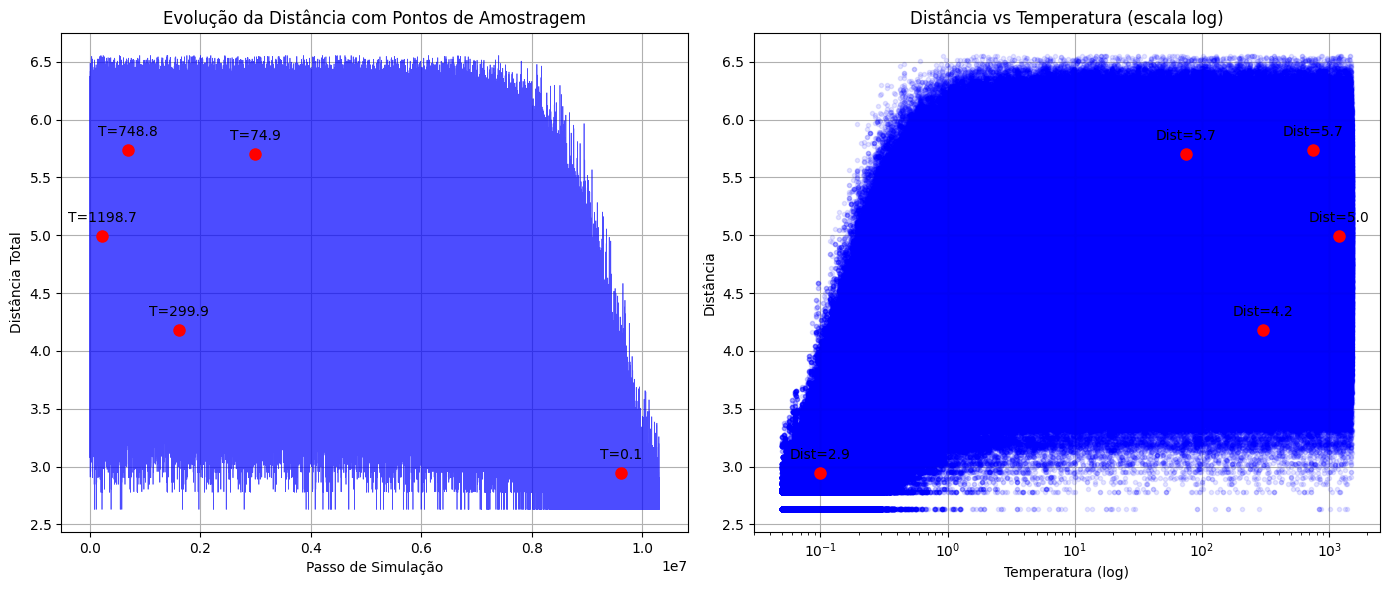

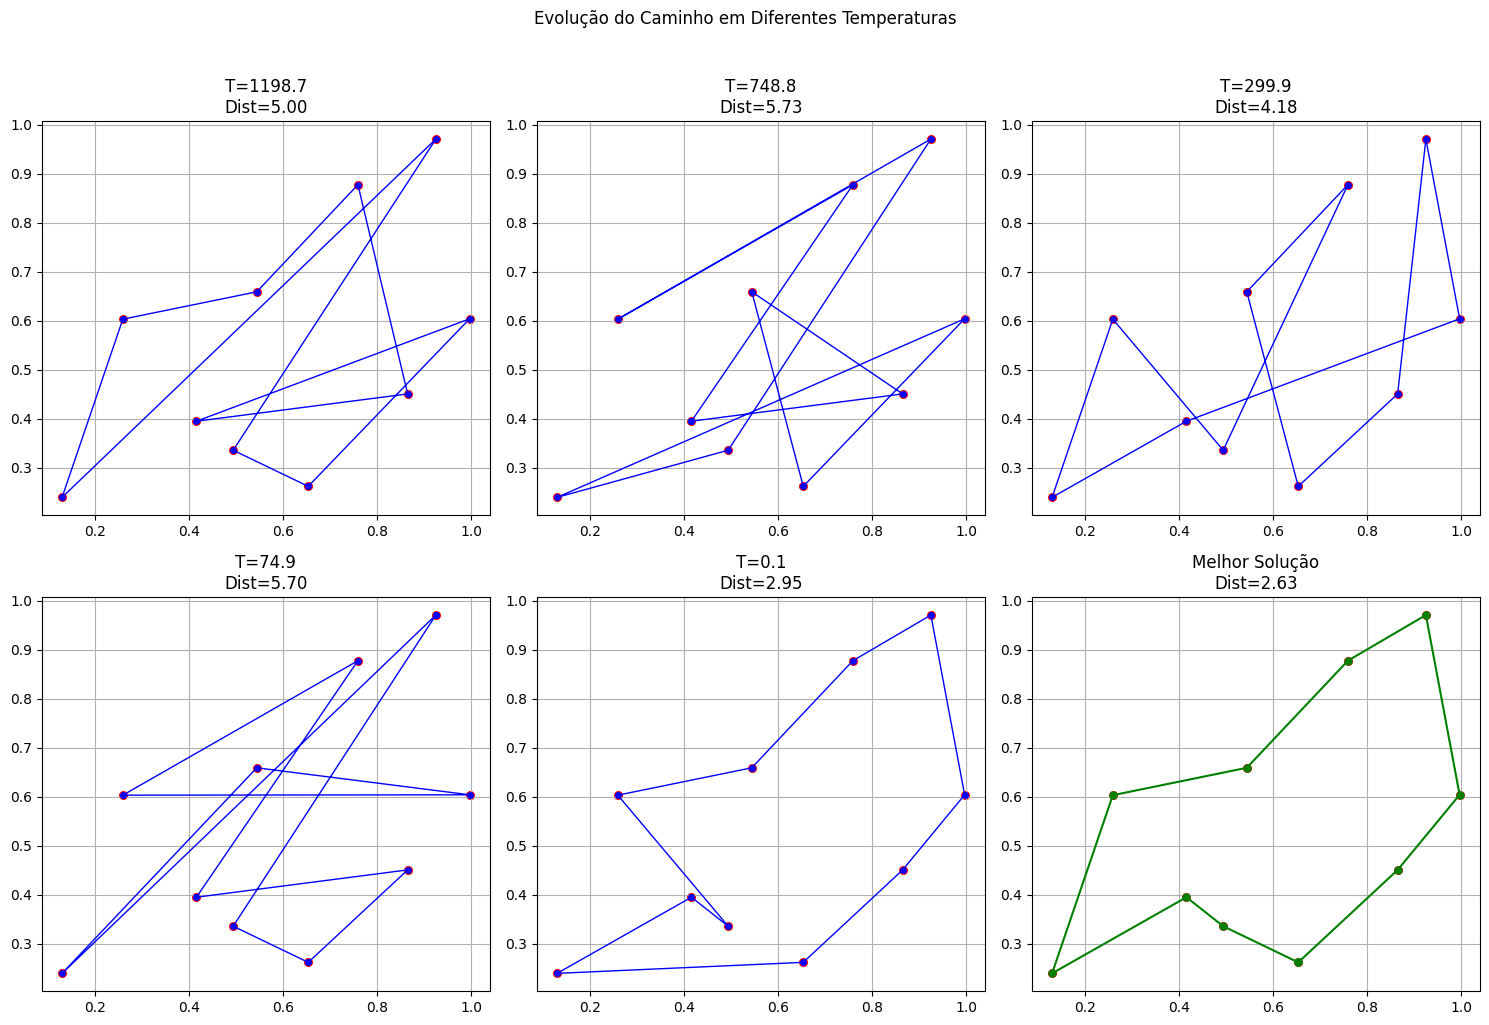


=== Resolvendo TSP para N=75 cidades ===

Resultados para N=75 cidades:
Melhor distância encontrada: 7.9226
Tempo de execução: 72.95 segundos
Número total de passos: 10300000


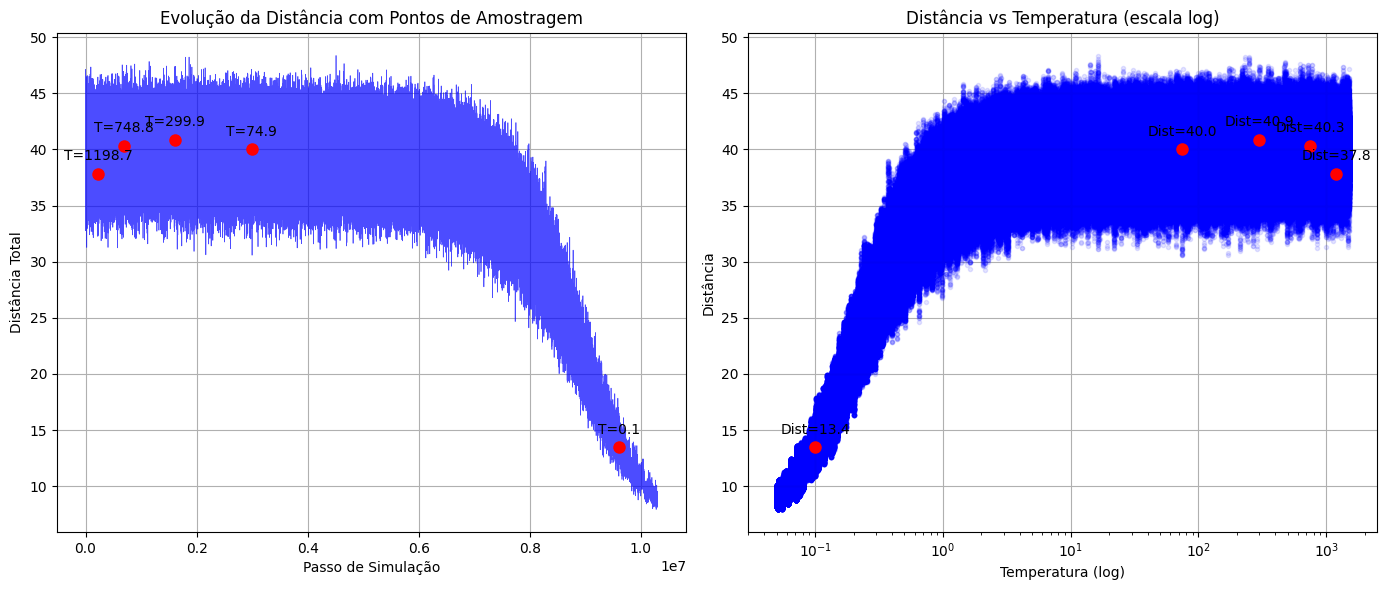

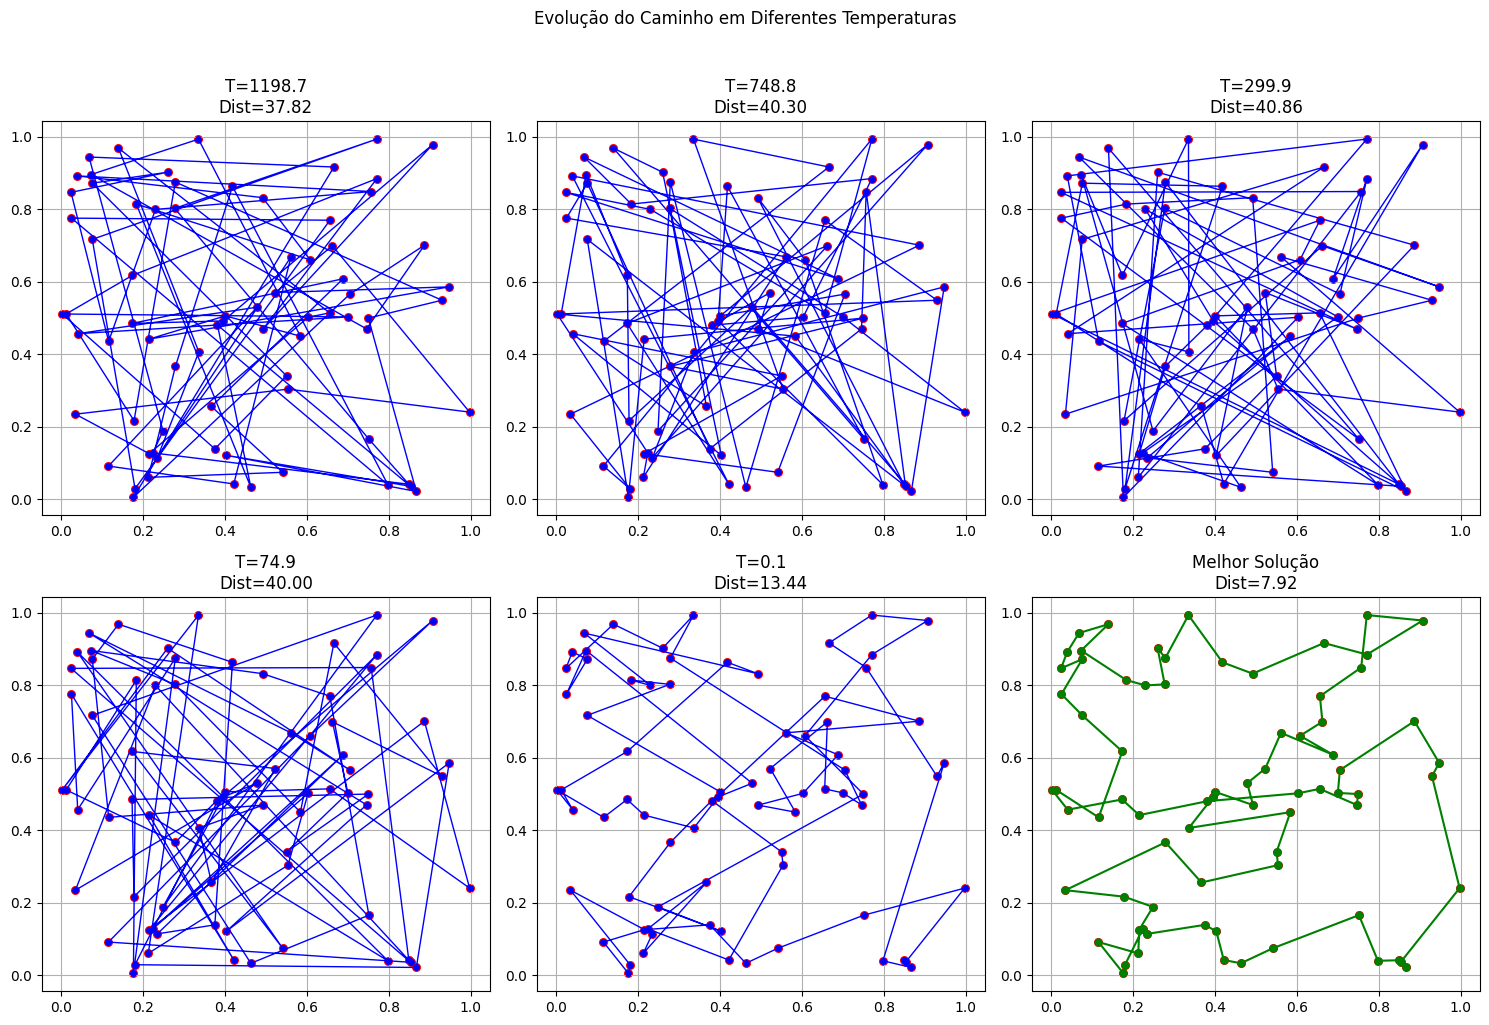


=== Resolvendo TSP para N=150 cidades ===

Resultados para N=150 cidades:
Melhor distância encontrada: 14.8433
Tempo de execução: 75.34 segundos
Número total de passos: 10300000


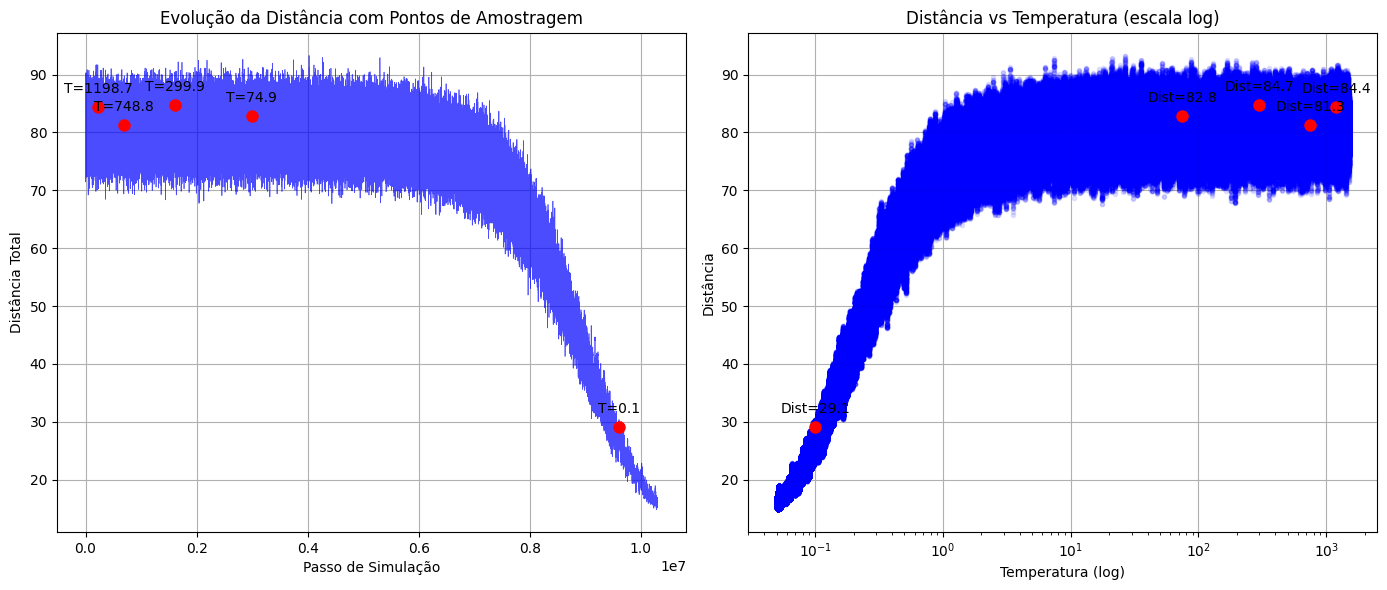

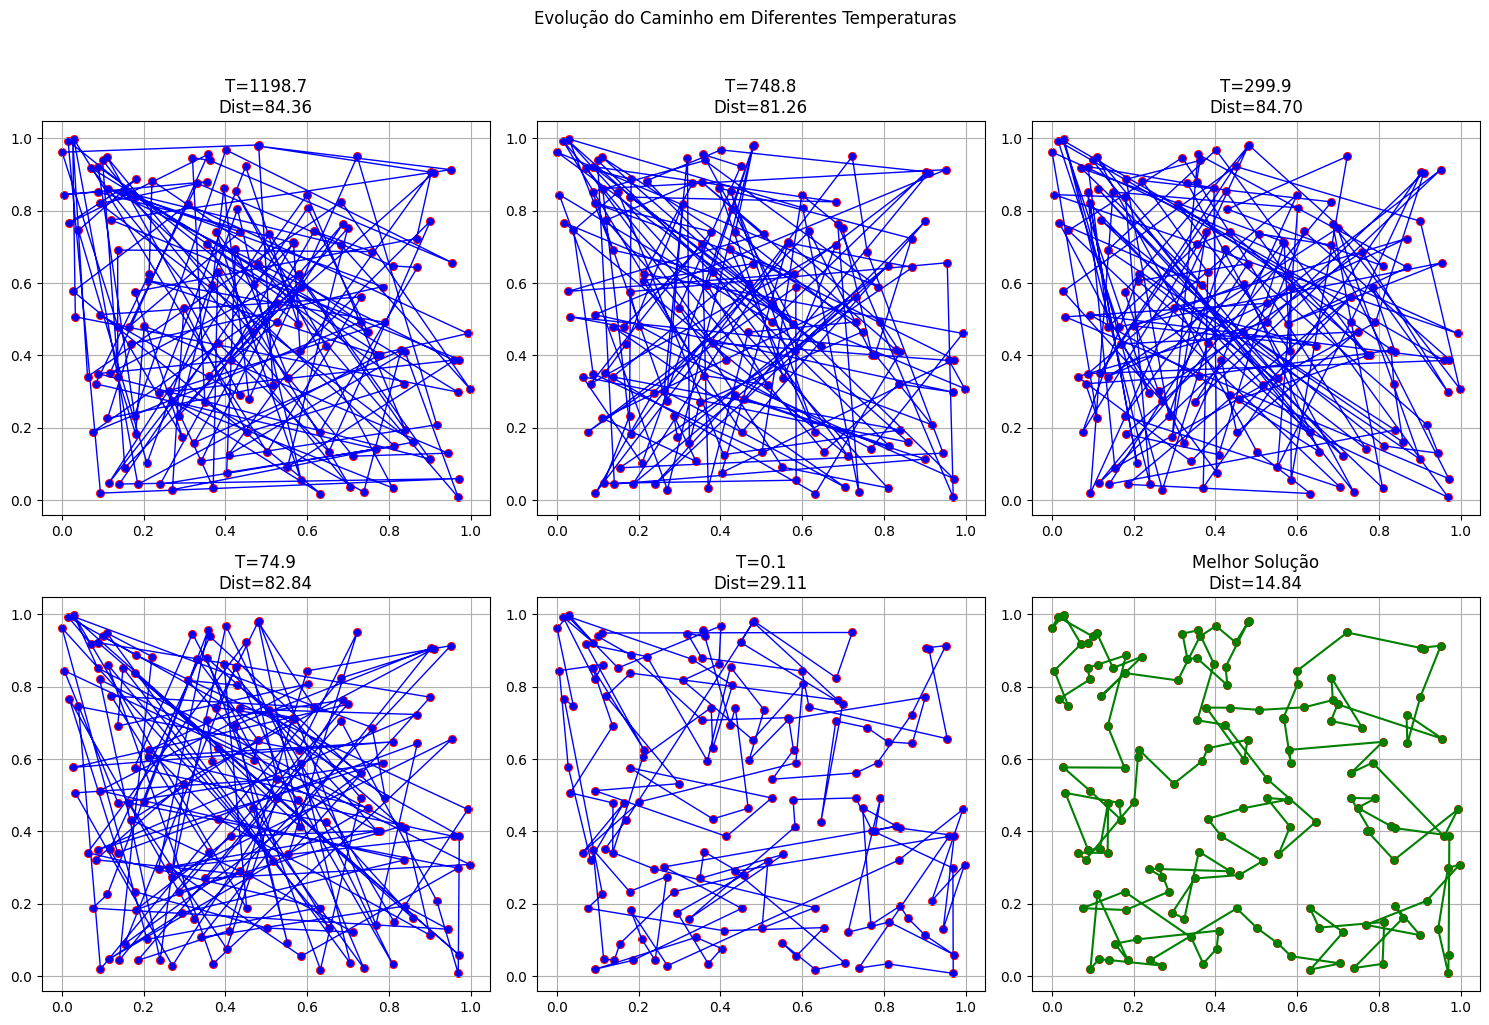

In [106]:
if __name__ == "__main__":
    n = [10, 75, 150]  # Tamanhos diferentes de problemas
    results = solve_tsp_problems(n)

# Conclusão
Tanto o Algoritmo Genético (AG) quanto o Simulated Annealing (SA) foram eficazes na resolução do Problema do Caixeiro Viajante, mas com características e desempenhos diferentes. O AG se destacou por ser rápido e eficiente, principalmente em casos com até 120 cidades. Ele usa boas estratégias, como manter os melhores caminhos, fazer mutações híbridas e a variedade de operadores de crossover, que permitiram misturar soluções diferentes, o que ajuda a encontrar respostas melhores com o tempo. Já o SA demora mais para rodar, mas costuma dar respostas mais estáveis e tem menos chance de ficar preso em soluções ruins. Por isso, ele pode funcionar melhor em problemas maiores.

Assim, ambos se complementam: um oferece agilidade com boa qualidade, o outro, segurança e estabilidade (mesmo que leve mais tempo). No futuro, uma ideia interessante seria juntar os dois métodos, usando o AG para explorar o problema e o SA para melhorar ainda mais o resultado encontrado.